# Exercise 2: Solving the Poisson Equation
![image.png](attachment:image.png)

In this exercise, we will solve the Poisson equation with FEniCS:

\begin{alignat}{2}
-\Delta u &= f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}} \\
-\partial_n u &= g \quad && \text{ on } \Gamma_{\mathrm{N}}
\end{alignat}

We will use the following data:

* $\Omega = (S_0 \cup S_1) \setminus (C_0 \cup C_1)$
* $S_0$ is the unit square centered at $(0.5, 0.5)$
* $S_1$ is the unit square centered at $(1, 1)$
* $C_0$ is a circle with radius $0.25$ centered at $(0.5, 0.5)$
* $C_1$ is a circle with radius $0.25$ centered at $(1, 1)$
* $\Gamma_{\mathrm{D}} = $ the boundaries of the two circles
* $\Gamma_{\mathrm{N}} = \partial\Omega \setminus \Gamma_{\mathrm{D}}$
* $f(x, y) = \exp(-10((x - 0.75)^2 + (y - 0.75)^2))$
* $u_{\mathrm{D}} = 0$
* $g = 0$

![poisson_domains.png](attachment:poisson_domains.png)

For hints and more reading on how to solve the Poisson problem in FEniCS, see the [section on the Poisson problem](https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:fundamentals) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Importing FEniCS
The first thing we need to do is to import FEniCS. We will also need to import the meshing library `mshr`.

In [1]:
from fenics import *
from mshr import *

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [2]:
%matplotlib inline

## Creating the mesh
To create the mesh, use boolean operators (CSG = Constructive Solid Geometry) from `mshr`. Define the two squares and circles, then combine them with operators `+` (union), `*` (intersection) and `-` (set difference). (Only union and set difference will be needed for this exercise.)

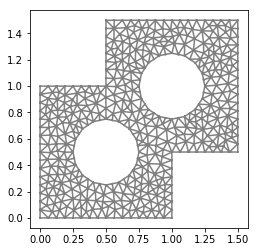

In [3]:
S0 = Rectangle(Point(0, 0), Point(1, 1))
S1 = Rectangle(Point(0.5,0.5),Point(1.5,1.5))
C0 = Circle(Point(0.5,0.5),0.25)
C1 = Circle(Point(1,1),0.25)
domain = (S0+S1)-(C0+C1)
mesh = generate_mesh(domain,20)
plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. We will use a standard piecewise linear $P_1$ function space.

In [4]:
V = FunctionSpace(mesh,'P',1)

## Defining the boundary condition
The boundary condition can be defined by specifying all points on the boundary closer to either of the two circle centers than a distance slightly larger than the radius $r = 0.25$. 

In [5]:
def boundary(x, on_boundary):
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    d1 = sqrt((x[0]-1.0)**2 + (x[1]-1.0)**2)
    return on_boundary and (d0 < 0.3 or d1 < 0.3)

bc = DirichletBC(V, 0 , boundary)

## Defining the variational problem
The finite element variational problem for the Poisson equation reads: Find $u \in V$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x.
\end{align}

In [6]:
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('exp(-10.0*(pow(x[0]-0.75,2) + pow(x[1] - 0.75,2)))',degree = 2)
a = inner(grad(u), grad(v))*dx
L = f*v*dx

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. Use the `plot` command to visualize the solution. 

  Calling FFC just-in-time (JIT) compiler, this may take some time.
  Calling FFC just-in-time (JIT) compiler, this may take some time.


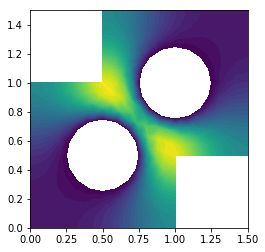

In [8]:
u = Function(V)
solve(a == L, u, bc)
plot(u)

## Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).